## **Gamma Variation Heuristic**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics


In [2]:
import seaborn as sns
sns.set()

### **BAS Dataset** 

In [3]:
gridsize = 2
bas = bas_dataset(grid_size= gridsize); wts = hebbing_learning(bas.dataset)


In [4]:
# define the model
np.random.seed(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = gridsize*gridsize

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

#evaluating J for BAS dataset
J=-1*wts   #np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])

# defining h
h=np.zeros(np.shape(J)[0])

# instantiate the model
model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {np.shape(J)[0]}")

            MODEL : BAS data of gridsize 4
Non-zero Interactions (J) : 2 / 6
Non-zero Bias (h) : 0 / 4
---------------------------------------------
Average Interaction Strength <|J|> :  1.0
Average Bias Strength <|h|>:  0.0
alpha :  0.35355339059327373
---------------------------------------------


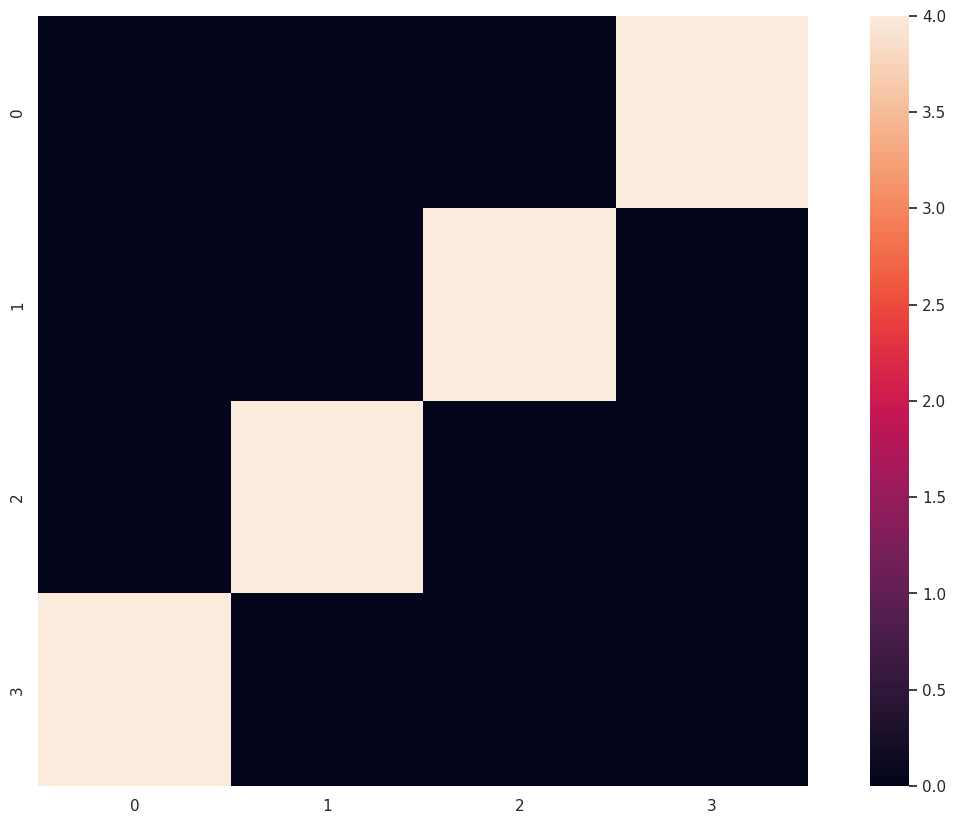

In [5]:
model.model_summary()

     MODEL : BAS data of gridsize 4 |  beta : 1
Num Most Probable States : 16
Entropy : 2.0087058847953743
---------------------------------------------


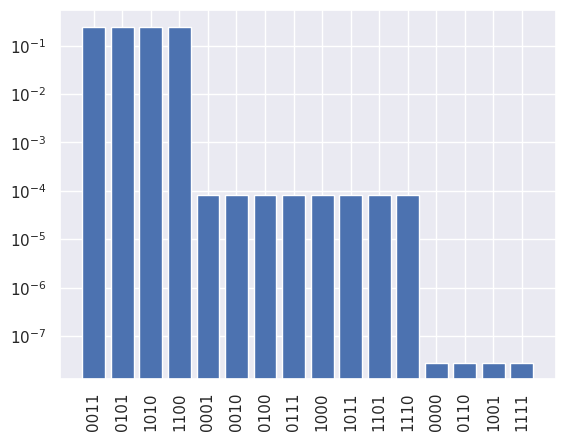

In [6]:
## set current beta
beta = 1#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary(show_threshold=1e-10)
plt.yscale("log")


#### **quMCMC for gamma variation**

In [7]:
initial_state = bas.dataset[0]
steps= 10000

In [8]:
qmcmc_basic_mixer = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    name = 'basic_mixer'
)

In [10]:
## Perturbative Gamma range : (0.001 -> 0.09)
qmcmc_advmix_pertgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.001, 0.09),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_pertgamma'
)

In [11]:
## Low Gamma range : (0.1 -> 0.25)
qmcmc_advmix_lowgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.1, 0.25),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmic_lowgamma'
)

In [12]:
## Medium Gamma range : (0.25 -> 0.75)
qmcmc_advmix_medgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.25, 0.75),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_medgamma'
)

In [13]:
## High Gamma range : (0.75 -> 0.9)
qmcmc_advmix_higamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.75, 0.9),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_higamma'
)

In [14]:
## Extreme Gamma range : (0.9 -> 0.9999)
qmcmc_advmix_extgamma = quantum_enhanced_mcmc(
    n_hops=steps,
    initial_state=initial_state,
    model=model,
    temperature=1/beta,
    gamma_range= (0.9, 0.9999),
    single_qubit_mixer= False, pauli_index_list= [1]*gridsize,
    name= 'advmix_extgamma'
)

##### **Analysis**

In [15]:
qchains = [qmcmc_basic_mixer, qmcmc_advmix_pertgamma, qmcmc_advmix_lowgamma, qmcmc_advmix_medgamma, qmcmc_advmix_higamma, qmcmc_advmix_extgamma]


kldivs = {}
for chain in qchains: kldivs[chain.name] = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, chain)

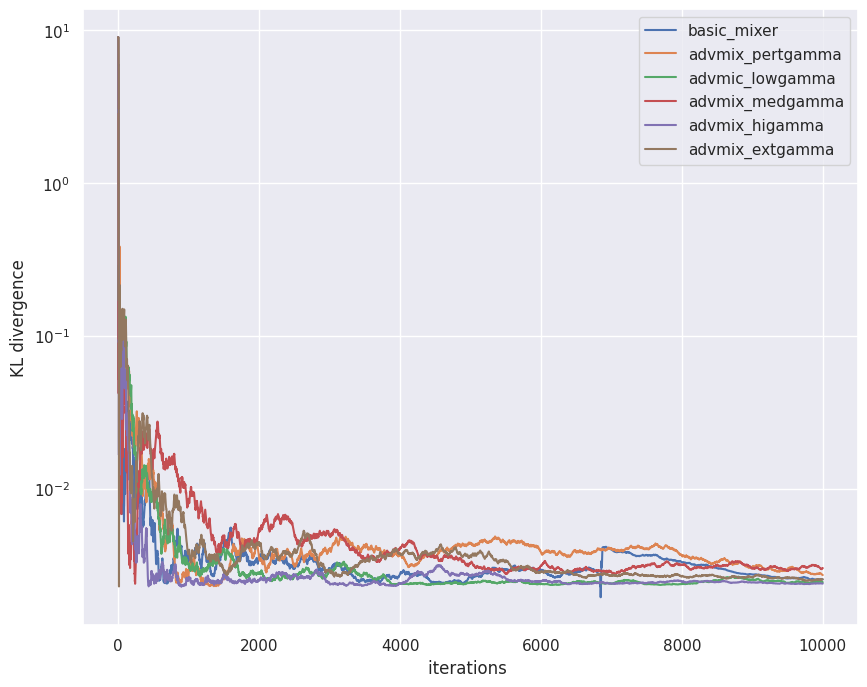

In [19]:
plt.figure(figsize=(10,8))

for items in kldivs.items():
    plt.plot(items[1], label= items[0])

plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
# plt.xscale("log")
plt.legend()
plt.show()